In [1]:
import os
import urllib.request
import zipfile

In [2]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
save_path = os.path.join(data_dir, "imagenet_class_index.json")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIP 파일을 읽는다
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIP을 압축 해제
    zip.close()  # ZIP 파일을 닫는다

    # ZIP 파일을 삭제
    os.remove(save_path)

## Dataset

In [10]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [11]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        # 훈련 시에는 epoch마다 데이터에 대한 random augmentation 수행
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # data augmentation
                transforms.RandomHorizontalFlip(),  # data augmentation
                transforms.ToTensor(),  # 텐서로 변환
                transforms.Normalize(mean, std)  # 표준화
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # 리사이즈
                transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize로 crop
                transforms.ToTensor(),  # 텐서로 변환
                transforms.Normalize(mean, std)  # 표준화
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

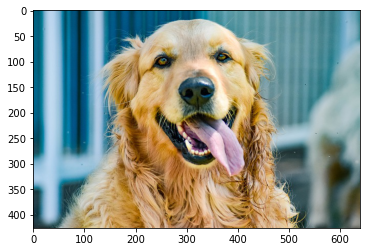

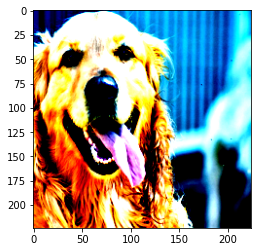

In [18]:
image_file_path = '/content/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [높이][폭][색RGB]

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)

img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [19]:
# 이미지 파일들의 경로 리스트
def make_datapath_list(phase="train"):
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath + phase + '/**/*.jpg')  # 파일 경로 문자열
    print(target_path)

    path_list = []
    
    # 파일 경로 불러오기
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

In [20]:
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


In [21]:
train_list[:5]

['./data/hymenoptera_data/train/ants/45472593_bfd624f8dc.jpg',
 './data/hymenoptera_data/train/ants/226951206_d6bf946504.jpg',
 './data/hymenoptera_data/train/ants/201790779_527f4c0168.jpg',
 './data/hymenoptera_data/train/ants/1489674356_09d48dde0a.jpg',
 './data/hymenoptera_data/train/ants/424873399_47658a91fb.jpg']

In [22]:
# Dataset 클래스
class HymenopteraDataset(data.Dataset):
    """
    이미지 Dataset 클래스. PyTorch의 Dataset 클래스를 상속

    Attributes
    ----------
    file_list : 리스트
        이미지 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]  # 특정 이미지의 파일 경로
        img = Image.open(img_path)  # [높이][너비][색RGB]
        
        img_transformed = self.transform(img, self.phase)  # (3, 224, 224)
        
        # 라벨명 추출
        if self.phase == 'train':
            label = img_path[30:34]
        elif self.phase == 'val':
            label = img_path[28:32]
        
        # 라벨명 변경 (숫자로)
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1

        return img_transformed, label  

In [23]:
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

In [24]:
# 동작 확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


## DataLoader

In [25]:
batch_size = 32

# DataLoader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)  # 이미지를 꺼내는 순서가 랜덤이 되게 함

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 딕셔너리에 train/val을 구별해서 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복자(iterator)로 변환
inputs, labels = next(batch_iterator)  # batch_size 개수 만큼 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 1])


## 네트워크 모델

In [26]:
use_pretrained = True  # 학습된 파라미터를 사용
net = models.vgg16(pretrained=use_pretrained)
net

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
# 분류기의 마지막 출력층을 이진 분류 태스크에 맞게 변경
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드 설정
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 손실 함수 정의 & Optimizer

In [28]:
criterion = nn.CrossEntropyLoss()

In [29]:
params_to_update = []  # 전이 학습에서 학습시킬 파라미터를 저장
update_param_names = ["classifier.6.weight", "classifier.6.bias"]  # 위에서 변경한 classifier의 6번째 layer의 가중치

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True  # backward 과정에서 gradient를 계산하여 가중치를 갱신하도록 설정
        params_to_update.append(param)
        print(name)
    else:
      param.requires_grad = False  # 위에서 변경하지 않은 나머지 layer는 가중치 동결 (갱신x)

print("-----------------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------------
[Parameter containing:
tensor([[-0.0006, -0.0091, -0.0007,  ..., -0.0124, -0.0107, -0.0117],
        [-0.0110, -0.0153,  0.0147,  ..., -0.0007, -0.0115,  0.0123]],
       requires_grad=True), Parameter containing:
tensor([ 0.0130, -0.0119], requires_grad=True)]


In [30]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## 학습

In [31]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
            else:
                net.eval()   # 모델을 검증 모드로

            epoch_loss = 0.0  # epoch 손실의 합
            epoch_corrects = 0  
            
            # 미학습
            if (epoch == 0) and (phase == 'train'):
                continue

            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)  # 라벨 index 예측
                    
                    # 학습 시에는 오차역전파 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0) 
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [ ]:
num_epochs = 5
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/5
-------------


 20%|██        | 1/5 [00:17<01:08, 17.18s/it]


KeyboardInterrupt: ignored

## Fine-tuning

모든 층의 파라미터를 다시 학습시키되 입력층의 가까운 부분의 파라미터는 학습률을 작게(혹은 변화시키지 않고), 출력층에 가까운 부분의 학습률은 크게 설정

In [7]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import models

from tqdm import tqdm

In [8]:
criterion = nn.CrossEntropyLoss()

In [32]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
# Fine-tuning으로 학습할 파라미터 목록
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 학습시킬 층의 파라미터명 지정
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias",
                        "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# 파라미터를 각각 리스트에 저장
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1에 저장: ", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2에 저장: ", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3에 저장: ", name)

    else:
        param.requires_grad = False
        print("경사 계산없음. 학습하지 않음: ", name)

params_to_update_1에 저장:  features.0.weight
params_to_update_1에 저장:  features.0.bias
params_to_update_1에 저장:  features.2.weight
params_to_update_1에 저장:  features.2.bias
params_to_update_1에 저장:  features.5.weight
params_to_update_1에 저장:  features.5.bias
params_to_update_1에 저장:  features.7.weight
params_to_update_1에 저장:  features.7.bias
params_to_update_1에 저장:  features.10.weight
params_to_update_1에 저장:  features.10.bias
params_to_update_1에 저장:  features.12.weight
params_to_update_1에 저장:  features.12.bias
params_to_update_1에 저장:  features.14.weight
params_to_update_1에 저장:  features.14.bias
params_to_update_1에 저장:  features.17.weight
params_to_update_1에 저장:  features.17.bias
params_to_update_1에 저장:  features.19.weight
params_to_update_1에 저장:  features.19.bias
params_to_update_1에 저장:  features.21.weight
params_to_update_1에 저장:  features.21.bias
params_to_update_1에 저장:  features.24.weight
params_to_update_1에 저장:  features.24.bias
params_to_update_1에 저장:  features.26.weight
params_to_update_1

In [34]:
# 각각 다른 학습률 적용
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [ ]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
            else:
                net.eval()   # 모델을 검증 모드로

            epoch_loss = 0.0  # epoch 손실의 합
            epoch_corrects = 0  
            
            # 미학습
            if (epoch == 0) and (phase == 'train'):
                continue

            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)  # 라벨 index 예측
                    
                    # 학습 시에는 오차역전파 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0) 
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [ ]:
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

In [ ]:
load_path = './weights_fine_tuning.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)